In [1]:
!pip install -q tensorflow keras scikit-learn tqdm seaborn ml_dtypes

import os, random, shutil, math, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [2]:
# 2️⃣ Dataset ayarları
# Dataset Google Drive veya Kaggle'dan Colab'e yüklenmiş olmalı
# Örneğin:
# /content/honey_bee_dataset/
# ├── images/
# │   ├── img_1.jpg
# │   ├── img_2.jpg ...
# ├── bee_data.csv  (kaggle datasetindeki etiket tablosu)

dataset_dir = "/content/drive/MyDrive/Colab Notebooks/bee_imgs"
images_dir = os.path.join(dataset_dir, "bee_imgs")
csv_path = os.path.join(dataset_dir, "bee_data.csv")

df = pd.read_csv(csv_path)
print("✅ Total Images:", len(df))
print("📁 Columns:", df.columns.tolist())

# Resize all images to (224,224)
for i, value in tqdm(enumerate(df['file']), total=len(df)):
    img_path = os.path.join(images_dir, os.path.basename(value))
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))
        img.save(img_path)


✅ Total Images: 5172
📁 Columns: ['file', 'date', 'time', 'location', 'zip code', 'subspecies', 'health', 'pollen_carrying', 'caste']


100%|██████████| 5172/5172 [33:07<00:00,  2.60it/s]


In [9]:
# ============================================================
# 2️⃣ Split dataset into train/test/val
# ============================================================

base_dir = "/content/bee_data_split"
train_path, test_path, val_path = [os.path.join(base_dir, x) for x in ["train", "test", "val"]]

for path in [train_path, test_path, val_path]:
    os.makedirs(path, exist_ok=True)
    for label in df['health'].unique():
        os.makedirs(os.path.join(path, label), exist_ok=True)

no_images = len(df)
train_size = math.floor(0.7 * no_images)
test_size = math.floor(0.2 * no_images)

images_list = list(df['file'])
random.seed(42)
random.shuffle(images_list)

train_images = images_list[:train_size]
test_images = images_list[train_size: train_size + test_size]
val_images = images_list[train_size + test_size:]

def move_images(image_list, target_path):
    for img in tqdm(image_list):
        label = df.loc[df['file'] == img, 'health'].values[0]
        src = os.path.join(images_dir, os.path.basename(img))
        dst = os.path.join(target_path, label, os.path.basename(img))
        if os.path.exists(src):
            shutil.copy(src, dst)

move_images(train_images, train_path)
move_images(test_images, test_path)
move_images(val_images, val_path)

# ============================================================
# 3️⃣ Data Augmentation + Generators
# ============================================================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=32, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(val_path, target_size=(224,224), batch_size=32, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(test_path, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False)


100%|██████████| 518/518 [00:03<00:00, 148.45it/s]

Found 3620 images belonging to 6 classes.
Found 518 images belonging to 6 classes.
Found 1034 images belonging to 6 classes.


In [10]:
# ============================================================
# 🐝 Honey Bee Disease Classification with EfficientNetB3
# ============================================================

!pip install -q tensorflow keras scikit-learn ml_dtypes

import os, random, shutil, math, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import applications

# ============================================================
# 1️⃣ Paths
# ============================================================
base_dir = "/content/bee_data_split"
train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")



In [20]:
# ============================================================
# 2️⃣ Data Generators
# ============================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path, target_size=(300, 300), batch_size=32, class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_directory(
    val_path, target_size=(300, 300), batch_size=32, class_mode='categorical'
)
test_gen = val_test_datagen.flow_from_directory(
    test_path, target_size=(300, 300), batch_size=32, class_mode='categorical', shuffle=False
)

with open("class_indices.pkl", "wb") as f:
    pickle.dump(train_gen.class_indices, f)
print("✅ class_indices.pkl kaydedildi:", train_gen.class_indices)

Found 3620 images belonging to 6 classes.
Found 518 images belonging to 6 classes.
Found 1034 images belonging to 6 classes.
✅ class_indices.pkl kaydedildi: {'Varroa, Small Hive Beetles': 0, 'ant problems': 1, 'few varrao, hive beetles': 2, 'healthy': 3, 'hive being robbed': 4, 'missing queen': 5}


In [12]:
# ============================================================
# 🐝 EfficientNetB3 Fine-Tuning (TF 2.19 / Keras 3 Fix)
# ============================================================

!pip install tensorflow==2.19.0 tensorflow-hub==0.16.1 --quiet

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# EfficientNetB3 feature vector (ImageNet pretrained)
MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

# TF Hub katmanını lambda ile sarmalıyoruz
def hub_feature_extractor(x):
    hub_layer = hub.load(MODEL_URL)
    return hub_layer(x)

# Model yapısı
inputs = tf.keras.Input(shape=(300, 300, 3))
x = tf.keras.layers.Lambda(hub_feature_extractor)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         9,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,222 (36.02 KB)

 Trainable params: 9,222 (36.02 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ============================================================
# 5️⃣ TRAINING
# ============================================================

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "bee_disease_model.h5", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3079 - loss: 1.6890
Epoch 1: val_accuracy improved from -inf to 0.64093, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1187s 10s/step - accuracy: 0.3093 - loss: 1.6870 - val_accuracy: 0.6409 - val_loss: 1.1519
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6760 - loss: 1.0791
Epoch 2: val_accuracy improved from 0.64093 to 0.64479, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1111s 10s/step - accuracy: 0.6758 - loss: 1.0792 - val_accuracy: 0.6448 - val_loss: 0.9830
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6706 - loss: 0.9758
Epoch 3: val_accuracy improved from 0.64479 to 0.68147, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1104s 10s/step - accuracy: 0.6706 - loss: 0.9755 - val_accuracy: 0.6815 - val_loss: 0.8696
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7082 - loss: 0.8522
Epoch 4: val_accuracy improved from 0.68147 to 0.73552, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1119s 10s/step - accuracy: 0.7081 - loss: 0.8521 - val_accuracy: 0.7355 - val_loss: 0.7823
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7289 - loss: 0.7622
Epoch 5: val_accuracy improved from 0.73552 to 0.77027, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1112s 10s/step - accuracy: 0.7289 - loss: 0.7623 - val_accuracy: 0.7703 - val_loss: 0.7158
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7524 - loss: 0.7127
Epoch 6: val_accuracy improved from 0.77027 to 0.79730, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1093s 10s/step - accuracy: 0.7524 - loss: 0.7127 - val_accuracy: 0.7973 - val_loss: 0.6643
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7755 - loss: 0.6578
Epoch 7: val_accuracy improved from 0.79730 to 0.82432, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1113s 10s/step - accuracy: 0.7755 - loss: 0.6578 - val_accuracy: 0.8243 - val_loss: 0.6222
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7880 - loss: 0.6347
Epoch 8: val_accuracy improved from 0.82432 to 0.83398, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1105s 10s/step - accuracy: 0.7881 - loss: 0.6345 - val_accuracy: 0.8340 - val_loss: 0.5840
Epoch 9/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7992 - loss: 0.5880
Epoch 9: val_accuracy improved from 0.83398 to 0.85328, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1129s 10s/step - accuracy: 0.7992 - loss: 0.5880 - val_accuracy: 0.8533 - val_loss: 0.5579
Epoch 10/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8168 - loss: 0.5569
Epoch 10: val_accuracy improved from 0.85328 to 0.85907, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1108s 10s/step - accuracy: 0.8169 - loss: 0.5568 - val_accuracy: 0.8591 - val_loss: 0.5302
Epoch 11/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8174 - loss: 0.5508
Epoch 11: val_accuracy improved from 0.85907 to 0.86293, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1113s 10s/step - accuracy: 0.8174 - loss: 0.5506 - val_accuracy: 0.8629 - val_loss: 0.5053
Epoch 12/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8296 - loss: 0.5074
Epoch 12: val_accuracy improved from 0.86293 to 0.86873, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1095s 10s/step - accuracy: 0.8297 - loss: 0.5073 - val_accuracy: 0.8687 - val_loss: 0.4857
Epoch 13/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8405 - loss: 0.4914
Epoch 13: val_accuracy improved from 0.86873 to 0.87066, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1103s 10s/step - accuracy: 0.8405 - loss: 0.4914 - val_accuracy: 0.8707 - val_loss: 0.4701
Epoch 14/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8378 - loss: 0.4869
Epoch 14: val_accuracy improved from 0.87066 to 0.87452, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1103s 10s/step - accuracy: 0.8379 - loss: 0.4867 - val_accuracy: 0.8745 - val_loss: 0.4530
Epoch 15/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8605 - loss: 0.4419
Epoch 15: val_accuracy improved from 0.87452 to 0.88031, saving model to bee_disease_model.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 1106s 10s/step - accuracy: 0.8604 - loss: 0.4419 - val_accuracy: 0.8803 - val_loss: 0.4431


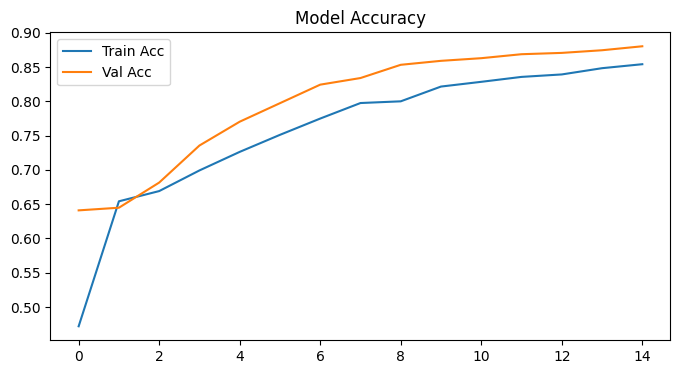

33/33 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.8037 - loss: 0.6007
✅ Test Accuracy: 87.52%


In [14]:
# ============================================================
# 6️⃣ PLOT TRAINING CURVES
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# ============================================================
# 7️⃣ TEST EVALUATION
# ============================================================

test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


In [15]:
# ============================================================
# 8️⃣ SAVE FINAL MODEL
# ============================================================

model.save("bee_disease_model_final.h5")
print("Model and label encoder saved successfully!")

Model and label encoder saved successfully!


In [23]:
# ============================================================
# 🐝 Tek Görsel Üzerinden Tahmin (class_indices.pkl Fix)
# ============================================================

import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub

# ✅ Aynı feature extractor fonksiyonu
MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

def hub_feature_extractor(x):
    hub_layer = hub.KerasLayer(MODEL_URL, trainable=False)
    return hub_layer(x)

# ✅ Modeli custom_objects ile yükle
model = load_model(
    "bee_disease_model_final.h5",
    custom_objects={'hub_feature_extractor': hub_feature_extractor},
    compile=False
)

# ✅ Label dictionary yükle
with open("class_indices.pkl", "rb") as f:
    class_dict = pickle.load(f)

# ✅ Dict ters çevriliyor (örnek: 0 → 'Varroa, Small Hive Beetles')
idx_to_label = {v: k for k, v in class_dict.items()}

# ✅ Test etmek istediğin görselin yolu
img_path = "/content/030_204.png"  # kendi test görselin

# ✅ Görseli yükle ve modele uygun hale getir
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# ✅ Tahmin yap
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
pred_label = idx_to_label.get(pred_class, "Unknown")

# ✅ Sonuçları yazdır
print("🎯 Tahmin Edilen Sınıf:", pred_label)
print("📊 Olasılıklar:", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
🎯 Tahmin Edilen Sınıf: ant problems
📊 Olasılıklar: [[0.02398365 0.56001836 0.12876227 0.20928706 0.05518933 0.02275935]]
